In [658]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import polars as plot
import glob
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import signal
from scipy.stats import circmean
from scipy import optimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import fsspec
#import intake_esm as intake
#import pandas as pd
from importlib import reload
import cartopy.io.shapereader as shapereader


In [2]:
import seasonality.seasonalityfunctions as sf
import seasonality.onset_demise as od

In [3]:
reload(od)
reload(sf)

<module 'seasonality.seasonalityfunctions' from '/Users/gbromley/code/PrecipitationSeasonality/seasonality/seasonalityfunctions.py'>

In [46]:
### Peru Domain ###
#min_lon = -83+360
#min_lat = -20.0
#max_lon = -67+360
#max_lat = 0.0



### processing CPC data 


cpc_files = glob.glob('/Users/gbromley/data/cpc_uni_global/precip.*.nc')
cpc_raw = xr.open_mfdataset(cpc_files)

### Setting coordinate data for next step 
lat = np.arange(-90, 90, 0.5)
lon = np.arange(0, 360, 0.5)
time = cpc_raw['time'].data

### transposing dimensions so the world is right side up 

flipped_cpc = np.flip(cpc_raw['precip'].values, axis=1)
### cpc latitudes are reversed so that they are decreasing instead of increasing. The following code reverses it. 
cpc_pr = xr.DataArray(flipped_cpc, coords=[('time', time), ('lat', lat), ('lon', lon)], name='precipitation')

### Selecting out Peru from the global data.
PERU = {'lat': slice(-20,0), 'lon': slice(360-83, 360-67)}
cpc_conus = cpc_pr.sel(lat = PERU['lat'], lon = PERU['lon'])

In [47]:
cpc_conus_anom = cpc_conus - cpc_conus.mean(dim='time')

In [639]:
sf.fourier_coefficients(sf.calc_annual_cycle(cpc_conus).values)

In [10]:
bom_files = glob.glob('/Users/gbromley/data/b17_cpc_onset-demise/onset.wet.season.CPC_UNI.*.nc')
test_bombardi = xr.open_mfdataset(sorted(bom_files), decode_cf = False, combine = 'nested', concat_dim='time')
test_bombardi = test_bombardi['DOY'].sel(PERU).squeeze()
test_bombardi = xr.where(test_bombardi == -999., np.nan, test_bombardi)

In [11]:
pd.date_range('1979', freq='YS', periods = 42)

DatetimeIndex(['1979-01-01', '1980-01-01', '1981-01-01', '1982-01-01',
               '1983-01-01', '1984-01-01', '1985-01-01', '1986-01-01',
               '1987-01-01', '1988-01-01', '1989-01-01', '1990-01-01',
               '1991-01-01', '1992-01-01', '1993-01-01', '1994-01-01',
               '1995-01-01', '1996-01-01', '1997-01-01', '1998-01-01',
               '1999-01-01', '2000-01-01', '2001-01-01', '2002-01-01',
               '2003-01-01', '2004-01-01', '2005-01-01', '2006-01-01',
               '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01',
               '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
               '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [12]:
test_bombardi['time'] = pd.date_range('1979', freq='YS', periods = 42)

In [13]:
test_bombardi

<xarray.DataArray 'DOY' (time: 42, lat: 41, lon: 33)>
dask.array<where, shape=(42, 41, 33), dtype=float32, chunksize=(1, 41, 33), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2020-01-01
    lev      int32 1000
  * lat      (lat) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... -1.5 -1.0 -0.5 0.0
  * lon      (lon) float64 277.0 277.5 278.0 278.5 ... 291.5 292.0 292.5 293.0

In [14]:
annual_cycle = sf.calc_annual_cycle(cpc_conus)

In [15]:
start_wet = od.B17_analysis_start(annual_cycle)

In [ ]:
sf.

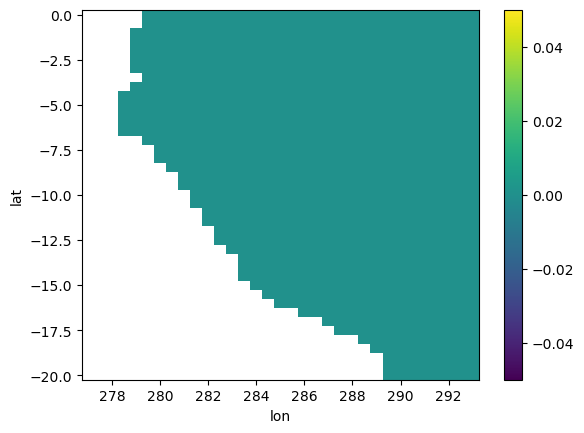

In [26]:
(start_wet - lm_onset.isel(year = 20)).plot()

In [348]:
reload(od)
time_slice = slice(4000, 4500)
test_loc = 20
temp = cpc_conus_anom.isel(lat=test_loc, lon=test_loc, time=time_slice)
temp_start = start_wet.isel(lat=test_loc, lon=test_loc)
test_data = od._onset_LM01(temp.values, time=temp.time,startWet=temp_start.values)
test_demise = od._demise_LM01(temp.values, time=temp.time,startWet=temp_start.values)

[Text(0.0, 0, '0.0'),
 Text(0.2, 0, '0.2'),
 Text(0.4, 0, '0.4'),
 Text(0.6000000000000001, 0, '0.6'),
 Text(0.8, 0, '0.8'),
 Text(1.0, 0, '1.0')]

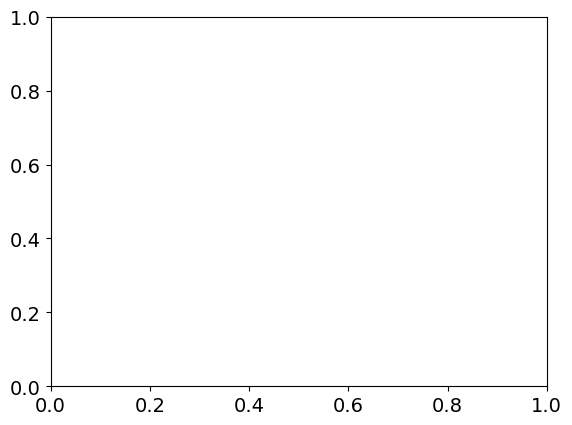

In [592]:
plt.gca().get_xticklabels()

In [527]:
import matplotlib.dates as mdates
import datetime
from matplotlib.legend_handler import HandlerLine2D

In [612]:
ax1.get_xlim()

(7262.05, 7810.95)

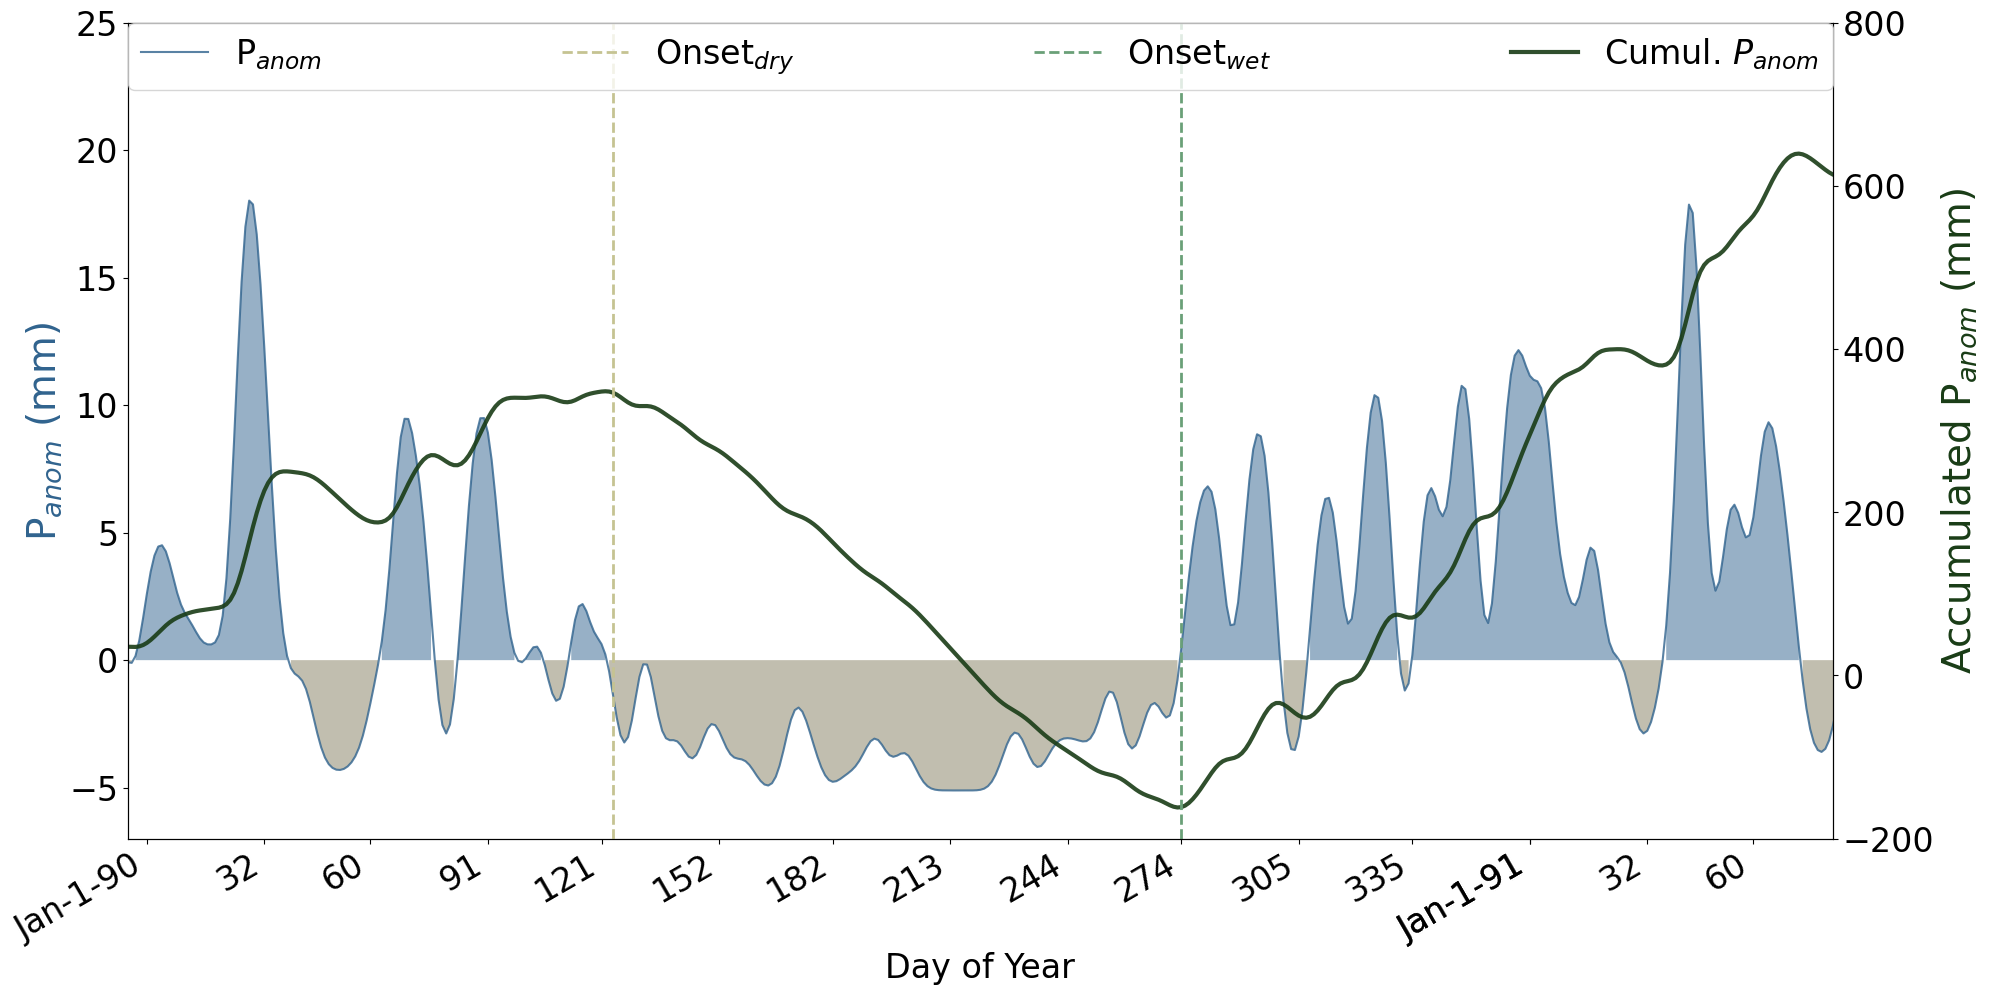

In [637]:
num_years = 2
pre_color = '#30638E'
#
# '#3FA7D6'
#
cumul_color = '#193C16'
#'#F18F01'
#'#0D1431'
plt.rcParams['font.size'] = 24

fs = plt.rcParams['font.size']
#orange = F18F01
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()
fig.set_size_inches((22,12))
# Plot the first data set with the first y-axis
anom_line = ax1.plot(temp.time, temp, pre_color, label=r'P$_{anom}$', alpha=0.8)  # 'g-' is for green solid line
ax1.set_xlabel('Day of Year')
ax1.set_ylabel(r'P$_{anom}$ (mm)', color=pre_color, fontsize=fs+4)  # Set the color of the y-axis label to green
ax1.tick_params(axis='y', labelcolor='black')

ax1.set_ylim(-7,25)

ax1.set_xlim(7300,7750)

ax1.fill_between(temp.time, temp, 0, alpha=0.5, where=temp > 0, facecolor = '#30638E')
ax1.fill_between(temp.time, temp, 0, alpha=0.5, where=temp < 0, facecolor='#857E61')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  
cumul = ax2.plot(temp.time, filtered_cumul, cumul_color, label=r'Cumul. $P_{anom}$', linewidth=3, alpha = 0.9)  # 'b-' is for blue solid line
ax2.set_ylabel(r'Accumulated P$_{anom}$ (mm)', color=cumul_color, fontsize=fs+4)  # Set the color of the y-axis label to blue
ax2.tick_params(axis='y', labelcolor='black')

ax2.set_ylim(-200, 800)
# Format date
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%j'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

current_ticks = plt.gca().get_xticks()[1:]
current_labels = [mdates.num2date(tick).strftime('%-j') for tick in current_ticks]

#annotated ticks
start_year = str(np.unique(temp.time.dt.year.values)[1])
years = pd.date_range(start = start_year, periods=num_years, freq='YS')

onset_doy = test_data[1:]
demise_doy = test_demise[1:]

onset_dates = np.empty_like(onset_doy, dtype=np.dtype('M8[D]'))
onset_dates[:] = np.datetime64("NaT")

demise_dates = np.empty_like(demise_doy, dtype=np.dtype('M8[D]'))
demise_dates[:] = np.datetime64("NaT")


for i,j in enumerate(onset_doy):
    
    if not np.isnan(j):
        
        onset_dates[i] = years[i] + pd.Timedelta(int(j), unit='day')
        
for i,j in enumerate(demise_doy):
    if not np.isnan(j):
        
        demise_dates[i] = years[i] + pd.Timedelta(int(j), unit='day')

ticks_str = years

ticks_to_add = [int(mdates.date2num(item)) for item in ticks_str]

#TODO clean all odf this up.
additional_labels = [mdates.num2date(year).strftime('%b-%-d-%y') for year in ticks_to_add]

# Combine current and additional ticks and labels
all_ticks = np.concatenate((current_ticks, ticks_to_add))
all_labels = current_labels + additional_labels



for i in onset_dates:
    if not np.isnan(i):
        onset_line = plt.axvline(x=i, ymin=0, ymax=1, color='#6AA078', linewidth=2, linestyle='--')

for j in demise_dates:
    if not np.isnan(j):
        demise_line = plt.axvline(x=j, ymin=0, ymax=1, color='#C5C392', linewidth=2, linestyle='--')


onset_line.set_label(r'Onset$_{ wet}$')
demise_line.set_label(r'Onset$_{ dry}$')
# Rotate date labels

legend_artists = [anom_line[0], demise_line, onset_line, cumul[0]]
legend_labels = [r'P$_{anom}$', r'Onset$_{ dry}$', r'Onset$_{ wet}$',r'Cumul. $P_{anom}$']
fig.legend(legend_artists, legend_labels, loc='lower left', bbox_to_anchor=(.1175, 0.81, 0.79, .25), ncols=4, mode='expand', frameon=True)

#ax1.set_title('Location: '+str(np.abs(temp.lat.values))+' S, '+str(temp.lon.values)+' W'+' (Peru)', x=0.5, y=1.05)

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.gca().set_xticks(all_ticks)
plt.gca().set_xticklabels(all_labels)
plt.gcf().autofmt_xdate(rotation=30)


# Set the combined ticks and labels

#plt.plot(temp.time, filtered_cumul)
#(temp*10).plot()
out_path = '/Users/gbromley/Dropbox/OU/Peru/'
plt.savefig(out_path+'Peru_Example.png', dpi=600, transparent=True)
plt.show()

In [567]:
all_labels[0].set_rotation(30)

In [597]:
all_labels

['1',
 '32',
 '60',
 '91',
 '121',
 '152',
 '182',
 '213',
 '244',
 '274',
 '305',
 '335',
 '1',
 '32',
 '60',
 '91',
 '121',
 '1-1-90',
 '1-1-91']

In [505]:
ax1.set_xlim(-7,20)

In [506]:
map_proj

<Derived Projected CRS: +proj=ortho +a=6378137.0 +lon_0=-75 +lat_0=-10 +no ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Orthographic
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [516]:
temp

<xarray.DataArray 'precipitation' (time: 500)>
array([13.571416  , 12.234079  ,  9.998314  ,  6.8735576 ,  3.7108517 ,
        1.2128402 , -0.27485117, -0.793153  , -0.6520004 , -0.25016424,
        0.08476949,  0.19011939,  0.08388542, -0.08209953, -0.10739201,
        0.1646728 ,  0.77818537,  1.6481792 ,  2.6037483 ,  3.4645016 ,
        4.1021624 ,  4.4543147 ,  4.504575  ,  4.2675586 ,  3.7999535 ,
        3.2107685 ,  2.6364362 ,  2.1790242 ,  1.8562678 ,  1.6087265 ,
        1.3635138 ,  1.0992571 ,  0.85706395,  0.69208807,  0.61938596,
        0.6168246 ,  0.69635457,  0.98538905,  1.7344508 ,  3.2135534 ,
        5.544344  ,  8.57151   , 11.86209   , 14.841936  , 16.995739  ,
       18.02153   , 17.872318  , 16.693386  , 14.725276  , 12.237181  ,
        9.506382  ,  6.810756  ,  4.401371  ,  2.4576185 ,  1.0547557 ,
        0.16554385, -0.31270817, -0.526828  , -0.64147925, -0.8091974 ,
       -1.13261   , -1.6333699 , -2.251143  , -2.8797245 , -3.42023   ,
       -3.820065  , -4.078714  , -4.226373  , -4.2958975 , -4.3067436 ,
       -4.2644987 , -4.167489  , -4.0088787 , -3.772658  , -3.432479  ,
       -2.9646037 , -2.3706834 , -1.687976  , -0.9617603 , -0.18663839,
        0.73528343,  1.9578546 ,  3.5698202 ,  5.4654703 ,  7.324719  ,
        8.74803   ,  9.465169  ,  9.457955  ,  8.906406  ,  8.014087  ,
        6.8693614 ,  5.448898  ,  3.7366712 ,  1.8358244 , -0.02065934,
       -1.5550736 , -2.5458937 , -2.875993  , -2.5211425 , -1.5215067 ,
...
        0.31955343,  0.12654051, -0.09342784, -0.47998542, -1.0443045 ,
       -1.6927338 , -2.288129  , -2.7070112 , -2.8740888 , -2.7709374 ,
       -2.422851  , -1.8673875 , -1.1113169 , -0.08866931,  1.3557217 ,
        3.4232783 ,  6.2401323 ,  9.688988  , 13.296224  , 16.29003   ,
       17.864826  , 17.536743  , 15.387656  , 12.04558   ,  8.422003  ,
        5.3670163 ,  3.419333  ,  2.7230246 ,  3.0774837 ,  4.054262  ,
        5.141443  ,  5.899395  ,  6.0957074 ,  5.7731857 ,  5.214361  ,
        4.8137817 ,  4.9038196 ,  5.604825  ,  6.762646  ,  8.014404  ,
        8.956833  ,  9.328286  ,  9.092983  ,  8.387848  ,  7.390422  ,
        6.217004  ,  4.909432  ,  3.4872653 ,  1.9995171 ,  0.53688467,
       -0.7913788 , -1.8910842 , -2.709057  , -3.2421901 , -3.5249994 ,
       -3.598535  , -3.4777737 , -3.1431165 , -2.5715704 , -1.7936797 ,
       -0.9322023 , -0.17396346,  0.33524722,  0.6160926 ,  0.9004674 ,
        1.5232719 ,  2.6960454 ,  4.306401  ,  5.9053583 ,  6.924707  ,
        6.9964957 ,  6.155874  ,  4.7927494 ,  3.4013655 ,  2.3192787 ,
        1.62421   ,  1.2159468 ,  0.9709916 ,  0.8374558 ,  0.8189939 ,
        0.899238  ,  0.99170244,  0.96183556,  0.6977732 ,  0.17131484,
       -0.55582005, -1.3751367 , -2.185738  , -2.9218528 , -3.5494068 ,
       -4.0506096 , -4.4174047 , -4.653752  , -4.7758765 , -4.8292036 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1989-12-14 1989-12-15 ... 1991-04-27
    lat      float64 -10.0
    lon      float64 287.0

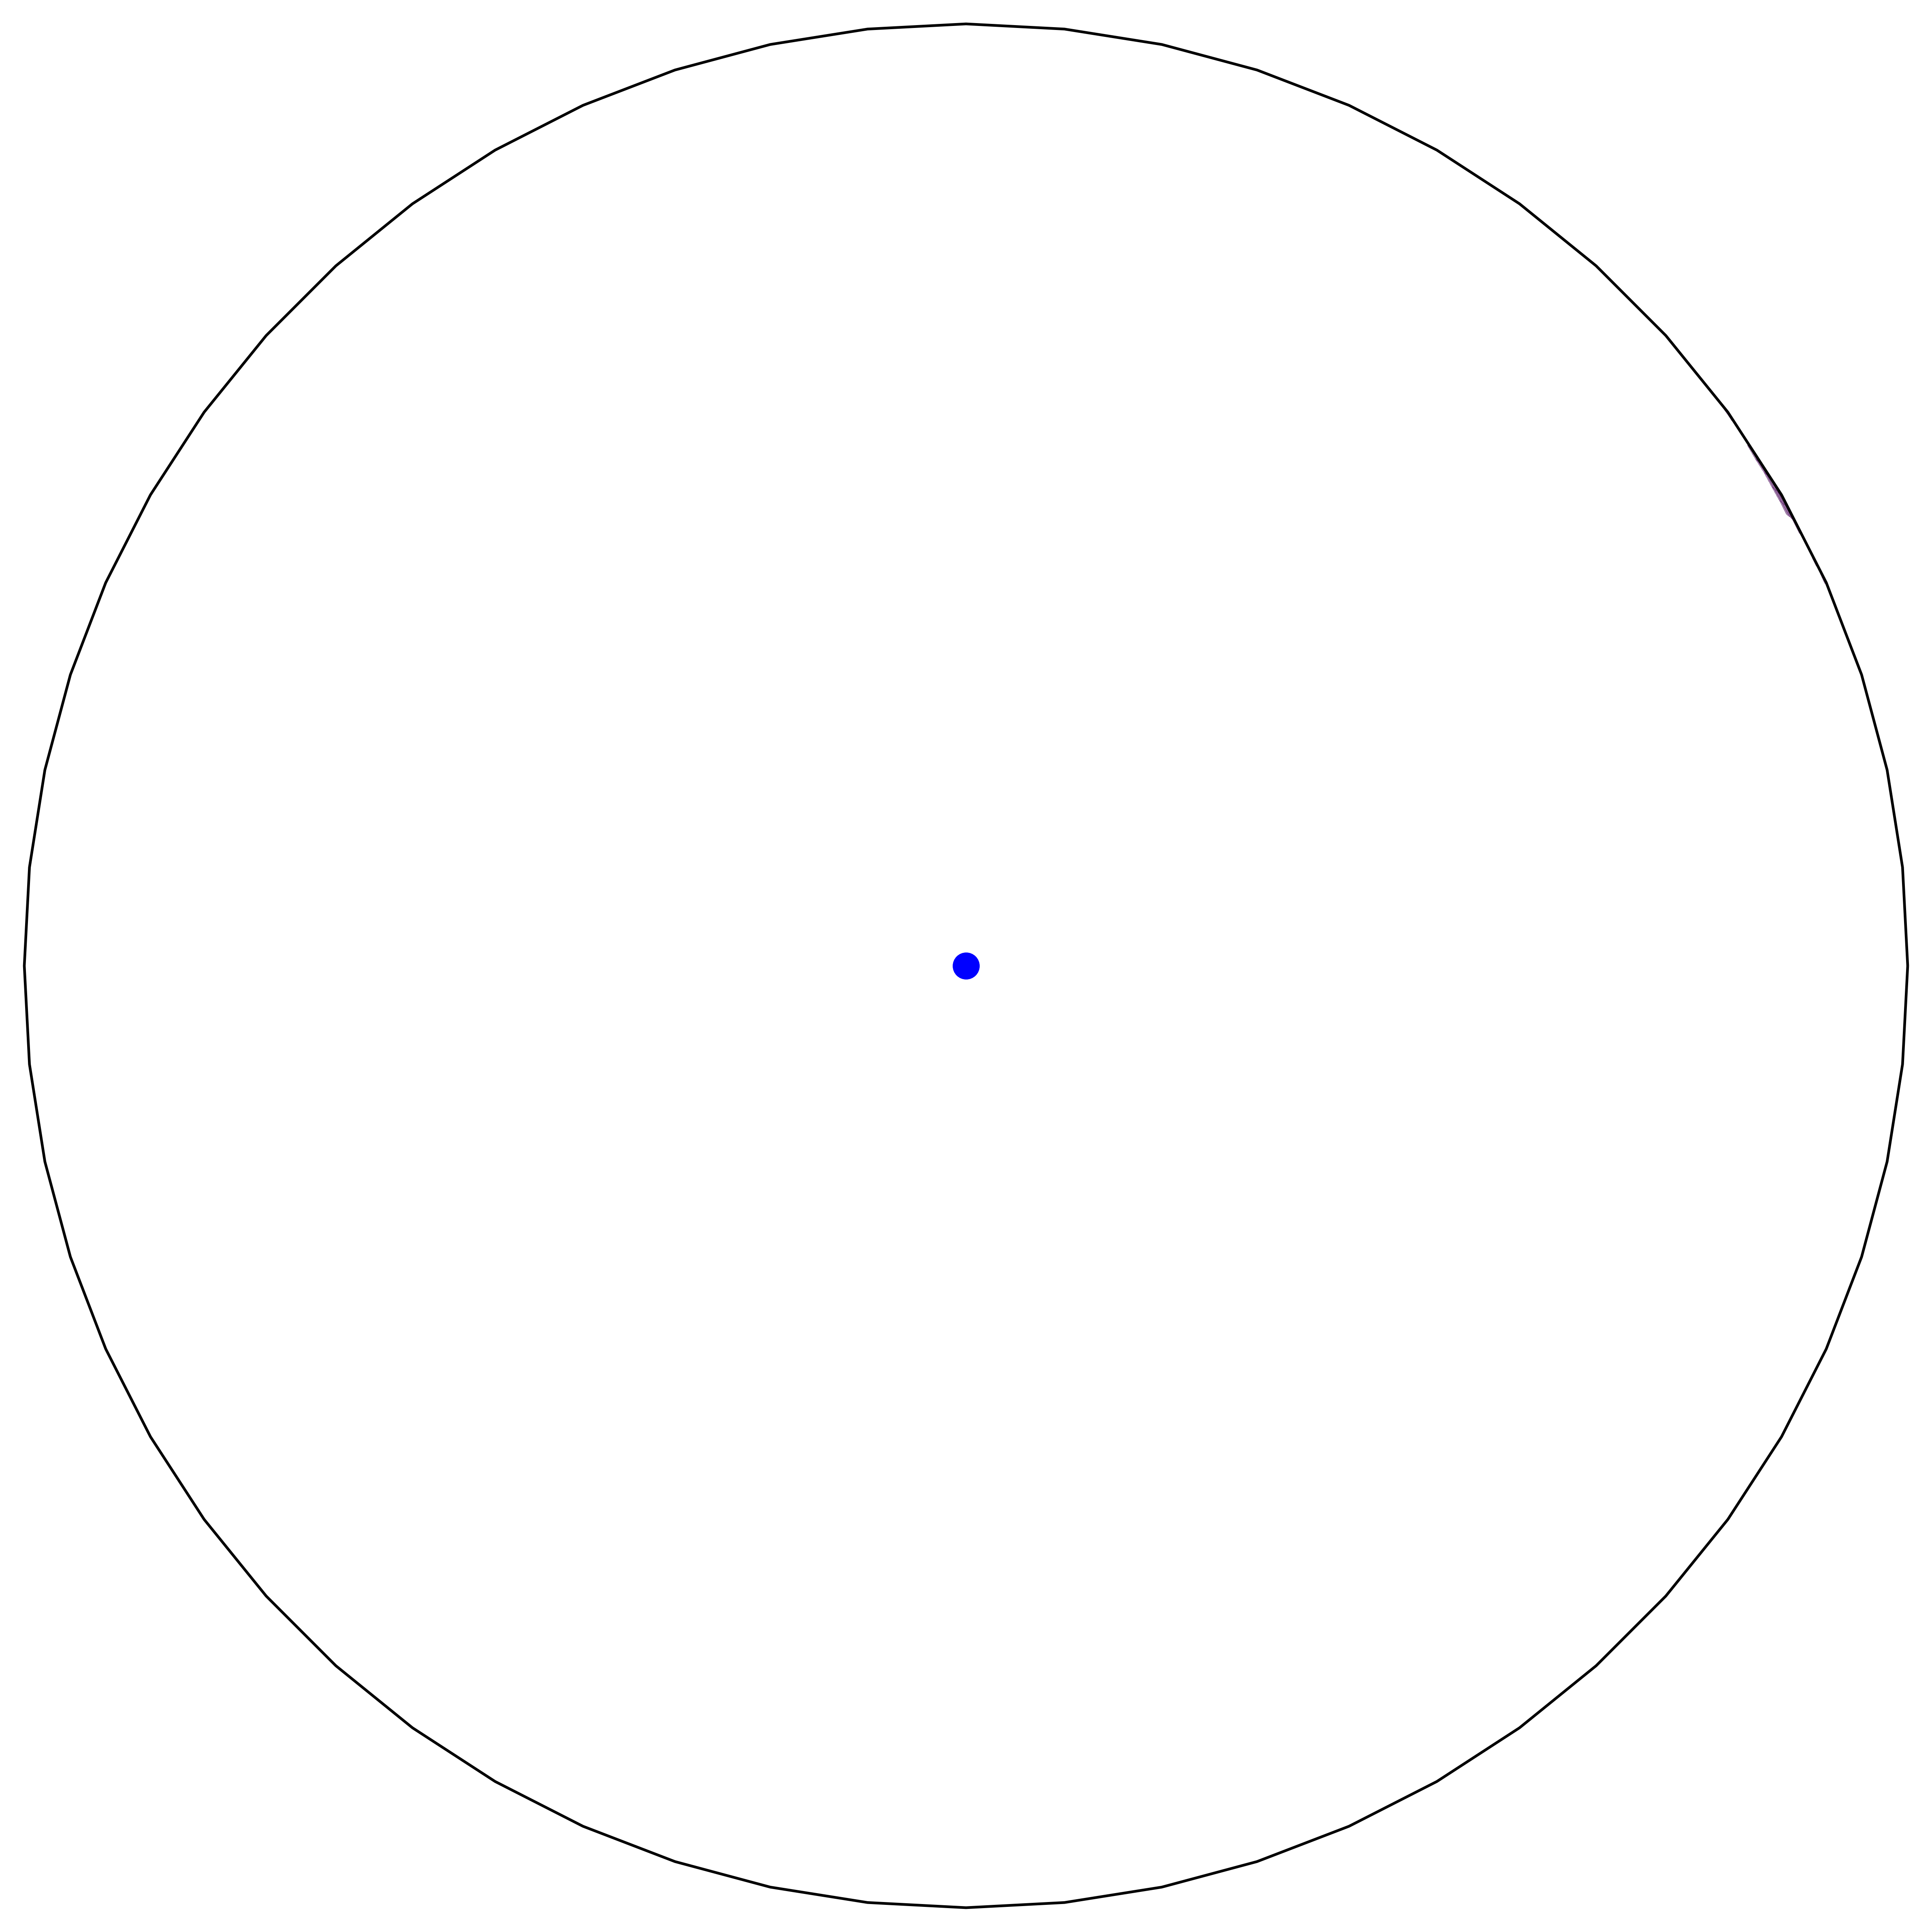

In [524]:
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText

map_proj = ccrs.Orthographic(central_longitude = -75, central_latitude= -10)



fig, ax = plt.subplots(1, 1, figsize=(10, 13), dpi=600,  subplot_kw={'projection': map_proj})

ax.pcolormesh(cpc_conus.isel(time=100).values, alpha=0.5, transform=ccrs.PlateCarree())

ax.set_global()

ax.plot(285,-10,'bo', markersize=7)


In [197]:
mdates.date2num(temp.time[0])

7287.0

In [192]:
current_ticks

array([7305., 7364., 7425., 7486., 7548., 7609., 7670., 7729., 7790.])

In [715]:
cpc_conus

<xarray.DataArray 'precipitation' (time: 12053, lat: 41, lon: 33)>
array([[[        nan,         nan,         nan, ...,  0.35015458,
          0.96914893,  2.269855  ],
        [        nan,         nan,         nan, ...,  0.68339807,
          1.1945915 ,  2.2104535 ],
        [        nan,         nan,         nan, ...,  0.8118185 ,
          1.3942424 ,  2.7595992 ],
        ...,
        [        nan,         nan,         nan, ..., 24.293789  ,
         16.116373  , 11.604905  ],
        [        nan,         nan,         nan, ..., 28.373438  ,
         10.614556  ,  2.9309943 ],
        [        nan,         nan,         nan, ..., 32.9004    ,
         15.565264  ,  4.5707383 ]],

       [[        nan,         nan,         nan, ...,  5.0659914 ,
          6.8278556 ,  3.184052  ],
        [        nan,         nan,         nan, ...,  7.9001555 ,
          8.851709  ,  6.819538  ],
        [        nan,         nan,         nan, ...,  8.800215  ,
          9.312223  ,  8.868947  ],
...
        [        nan,         nan,         nan, ...,  5.1540856 ,
          3.7945023 ,  4.5853224 ],
        [        nan,         nan,         nan, ...,  4.1152425 ,
          1.5678545 ,  1.642576  ],
        [        nan,         nan,         nan, ...,  4.8843007 ,
          2.1427984 ,  1.4690143 ]],

       [[        nan,         nan,         nan, ...,  7.39233   ,
          9.059651  , 10.146989  ],
        [        nan,         nan,         nan, ...,  6.9587746 ,
          8.024719  ,  9.312931  ],
        [        nan,         nan,         nan, ...,  6.6287856 ,
          7.236155  ,  8.257032  ],
        ...,
        [        nan,         nan,         nan, ...,  3.1272013 ,
          2.6472685 ,  2.5509982 ],
        [        nan,         nan,         nan, ...,  2.586707  ,
          2.6088357 ,  2.7078848 ],
        [        nan,         nan,         nan, ...,  2.251082  ,
          2.610687  ,  2.698397  ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2011-12-31
  * lat      (lat) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... -1.5 -1.0 -0.5 0.0
  * lon      (lon) float64 277.0 277.5 278.0 278.5 ... 291.5 292.0 292.5 293.0

In [716]:
reload(od)
reload(sf)
bom_demise = od.demise_B17(cpc_conus,start_wet)



ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

In [676]:
1990-1979

11

In [675]:
bom_onset['year'] 

<xarray.DataArray 'year' (year: 33)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])
Dimensions without coordinates: year

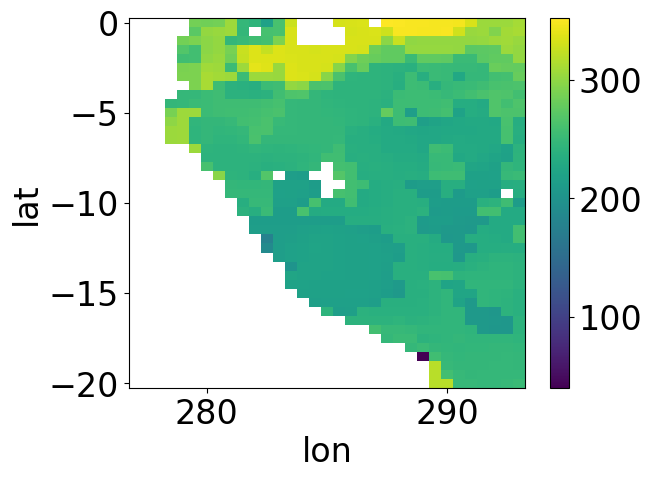

In [677]:
bom_onset.isel(year=11).plot()

In [649]:
lm_onset = od.onset_LM01(cpc_conus, start_wet)

In [ ]:
cpc_conus.plot.countour

/Users/gbromley/opt/anaconda3/envs/peru/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


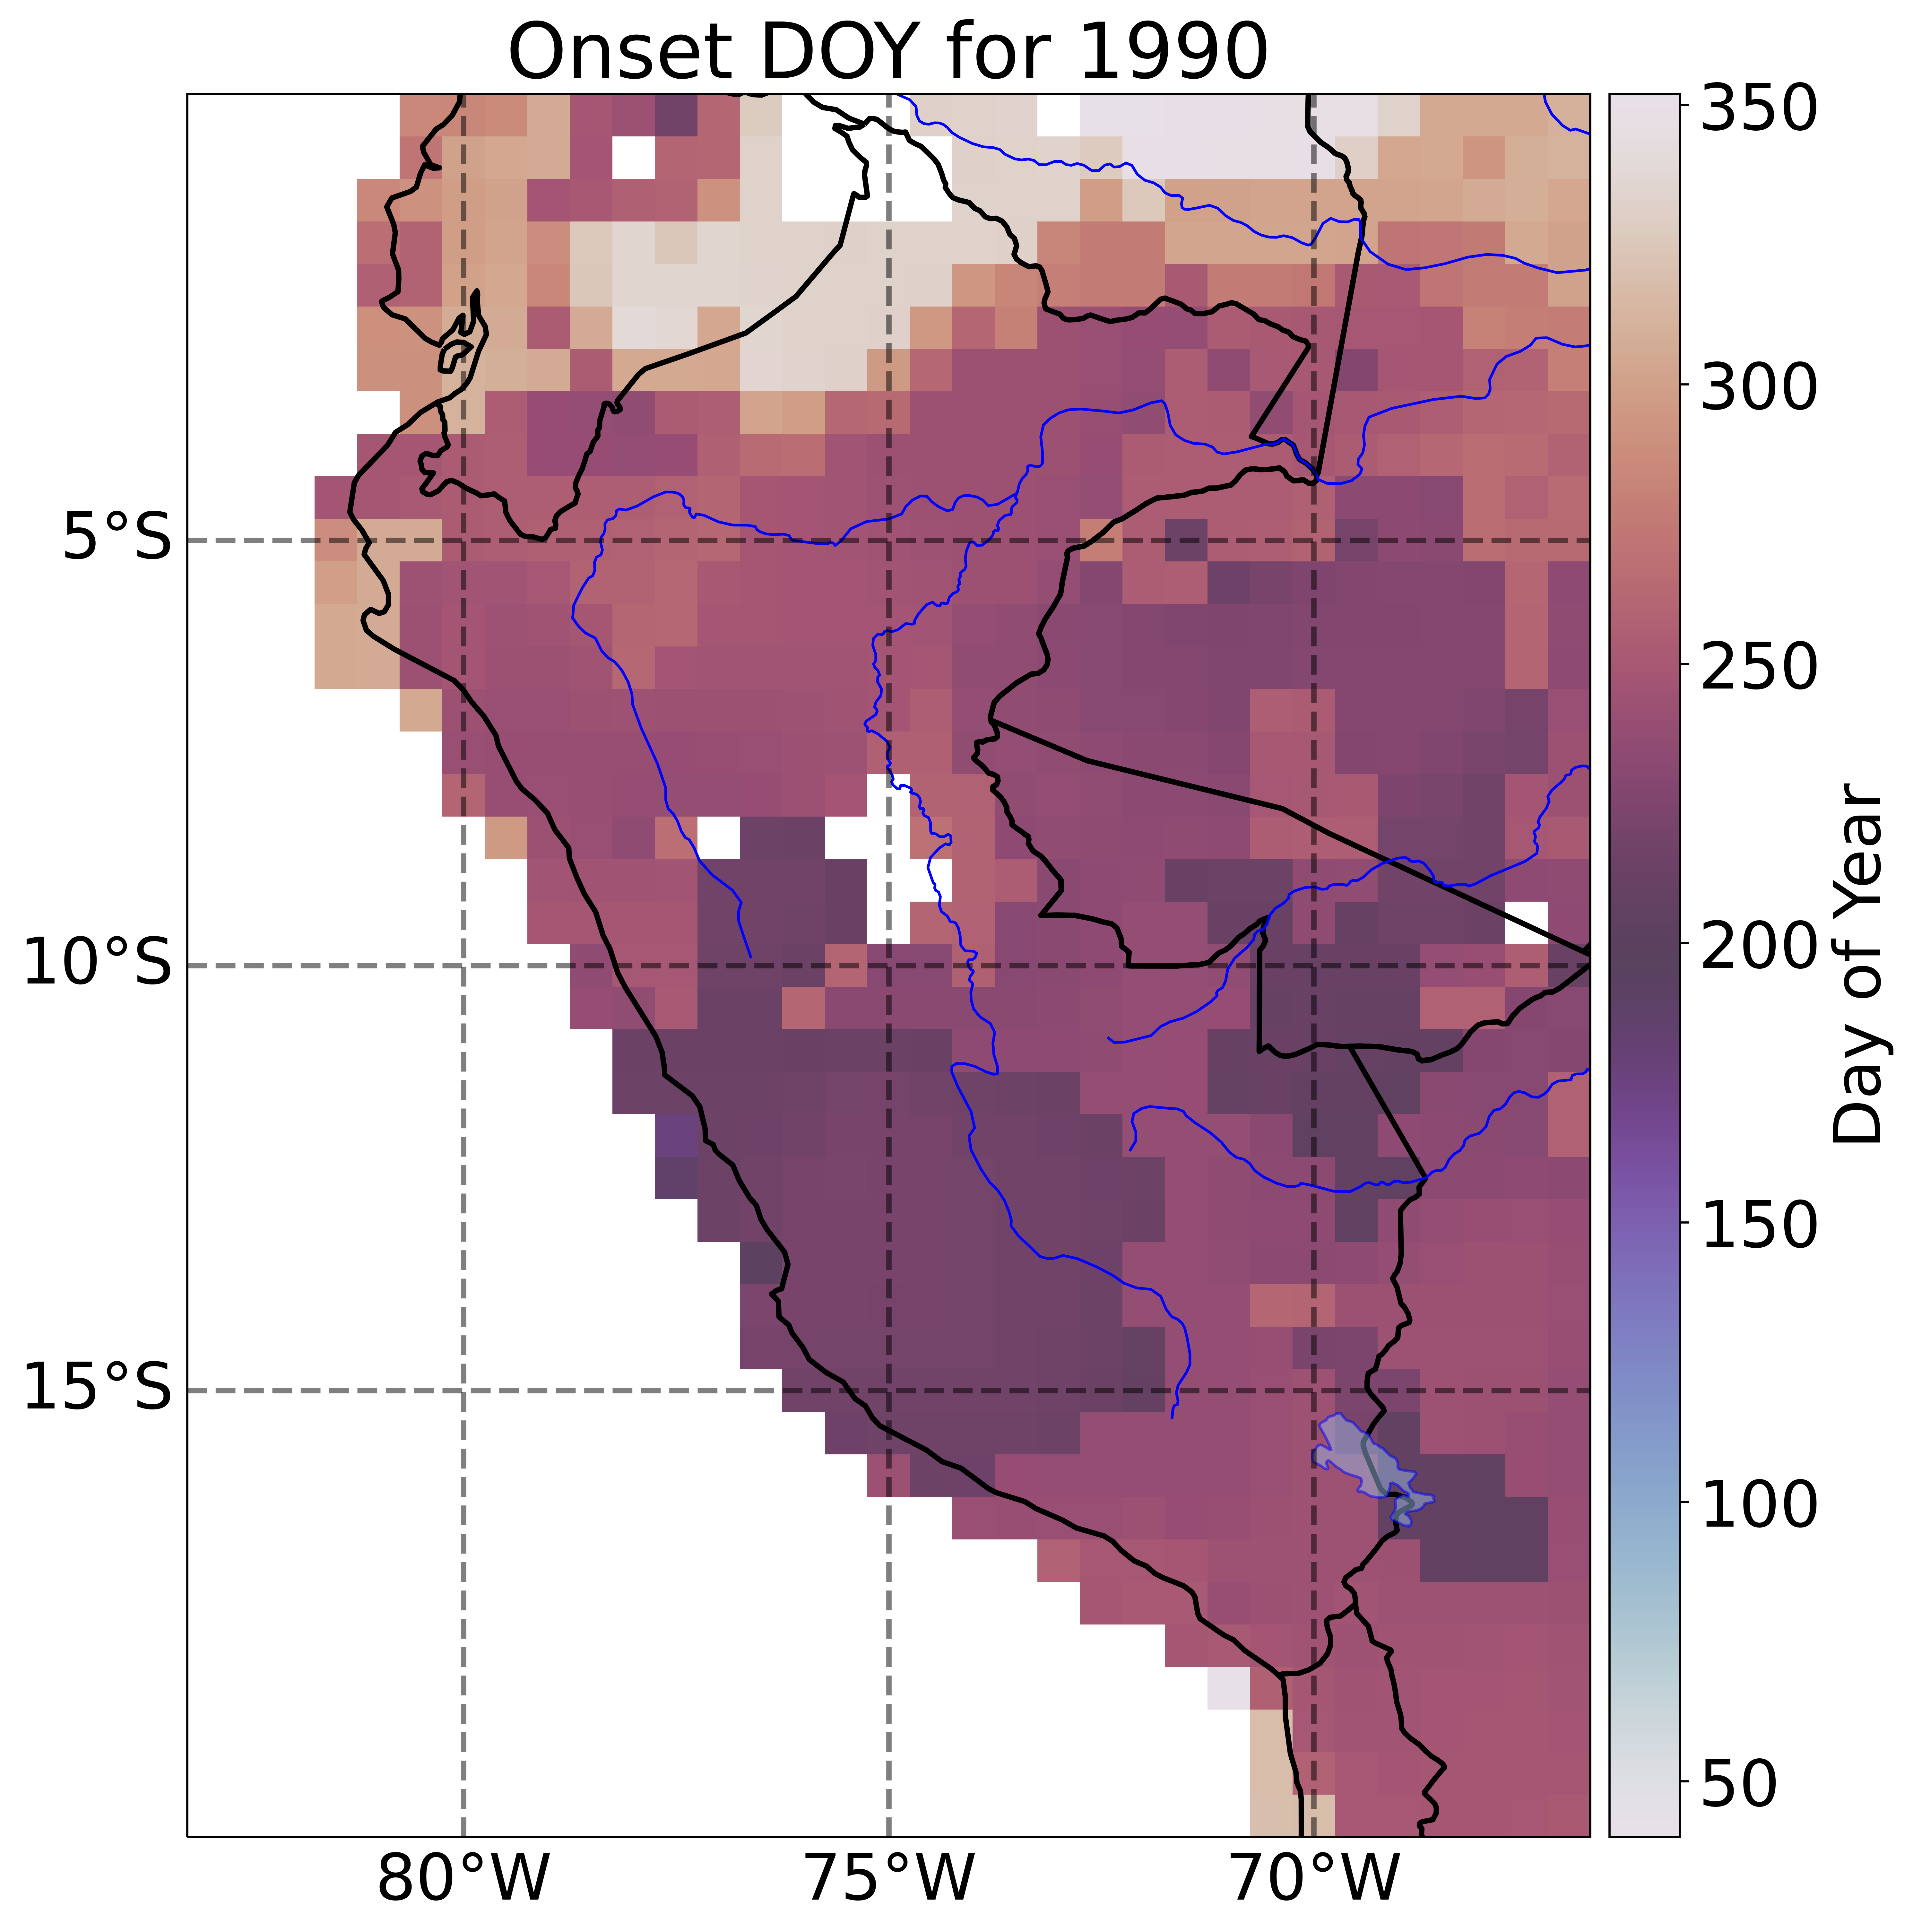

In [704]:
plot_spatial_data(bom_onset.isel(year=11), title='Onset DOY for 1990', var='Day of Year')

In [702]:
import matplotlib.ticker as mticker


from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def plot_spatial_data(dataarray, projection=ccrs.PlateCarree(), title='Spatial Data Plot', var='data_to_plot'):
    """
    Plots a spatial figure of a variable from an xarray DataArray.

    :param dataarray: xarray DataArray containing the geospatial data to be plotted.
    :param projection: Cartopy CRS projection. Defaults to PlateCarree.
    :param title: Title of the plot.
    """
    
    states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m')
    map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
    #cmap = mpl.cm.RdBu_r


    fig, ax = plt.subplots(1, 1, figsize=(10, 13), dpi=600,  subplot_kw={'projection': projection})
    p = dataarray.plot(ax=ax,transform=ccrs.PlateCarree(), add_colorbar=False, cmap='twilight',alpha = 0.8)


    ### Setting 1st plot parameters ###
    ax.coastlines(edgecolor='black', linewidth=2)
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=2)
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=2)
    ax.add_feature(cfeature.LAKES, alpha=0.5, edgecolor='blue')
    ax.add_feature(cfeature.RIVERS, color='blue')
    #ax1.set_xticks(np.arange(-180,181, 40))
    #ax1.set_yticks(np.arange(-90,91,15))
    drainage = shapereader.Reader('/Users/gbromley/Downloads/major_basins_of_the_world_0_0_0/Major_Basins_of_the_World.shp')
    #for feature in drainage.records():
    #    geometry = feature.geometry
    #    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=2, linestyle='--')
    #at = AnchoredText("a",
    #                    loc='upper left', prop=dict(size=8), frameon=True,)
    #at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    #ax1.add_artist(at)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    plt.colorbar(p, cax=cax, label=var)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=2, color='black', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator([280-360, 285-360, 290-360])
    gl.ylocator = mticker.FixedLocator([-5, -10, -15])
    gl.left_labels = True
    gl.right_labels = False
    gl.top_labels = False
    gl.bottom_labels = True

    # Add a title
    ax.set_title(title, loc='center')

    # Show the plot
    plt.show()

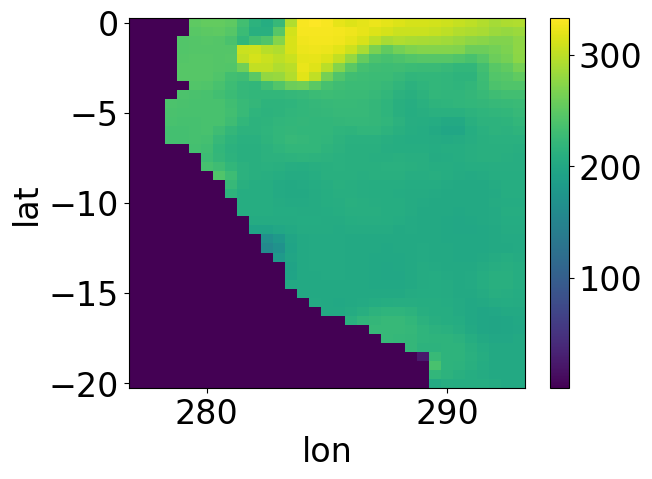

In [657]:
lm_onset.isel(year=11).plot()

In [171]:
tseries = np.nan_to_num(test_data)
    
smoothie = np.copy(tseries)
temp = np.copy(tseries)
    
for n in np.arange(0,1):
    temp[0] = 0.5*(smoothie[0]+smoothie[1])
    temp[-1] = 0.5*(smoothie[-1]+smoothie[-2])
    temp[1:-1] = 0.25*smoothie[0:-2] + 0.5*smoothie[1:-1]+0.25*smoothie[2:]
    smoothie = temp

In [185]:
0.25*smoothie[0:-2] + 0.5*smoothie[1:-1]+0.25*smoothie[2:]


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21.])

In [186]:
.25 * smoothie[0:-2]

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])

In [187]:
0.5*smoothie[1:-1]

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5])

In [184]:
(0.25*smoothie[2:]) + (0.5*smoothie[1:-1])

array([ 1.  ,  1.75,  2.5 ,  3.25,  4.  ,  4.75,  5.5 ,  6.25,  7.  ,
        7.75,  8.5 ,  9.25, 10.  , 10.75, 11.5 , 12.25, 13.  , 13.75,
       14.5 , 15.25, 16.  ])

In [172]:
temp

array([ 0.5,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. ,
       11. , 12. , 13. , 14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. ,
       21.5])

In [182]:
smoothie = np.copy(tseries)
0.25*smoothie[0:-2] + 0.5*smoothie[1:-1] + 0.25*smoothie[2:]



array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21.])

In [183]:
temp

array([ 0.5,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. ,
       11. , 12. , 13. , 14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. ,
       21.5])

In [142]:
reload(sf)
test_data = np.arange(0, 22.5, 1)
#test_data[0] = np.nan
#print(test_data)
nans = np.empty_like(test_data)
nans[:] = np.nan    

output = sf.smooth_B17(test_data)

#check =  not np.all(np.isnan(output))

In [144]:
len(output)

23

In [138]:
arr = np.random.rand(20)

    # Choose 3 random indices to replace with np.nan
    # np.random.choice generates a random sample from the given array
nan_indices = np.random.choice(20, 3, replace=False)

    # Replace the chosen indices with np.nan
arr[nan_indices] = np.nan

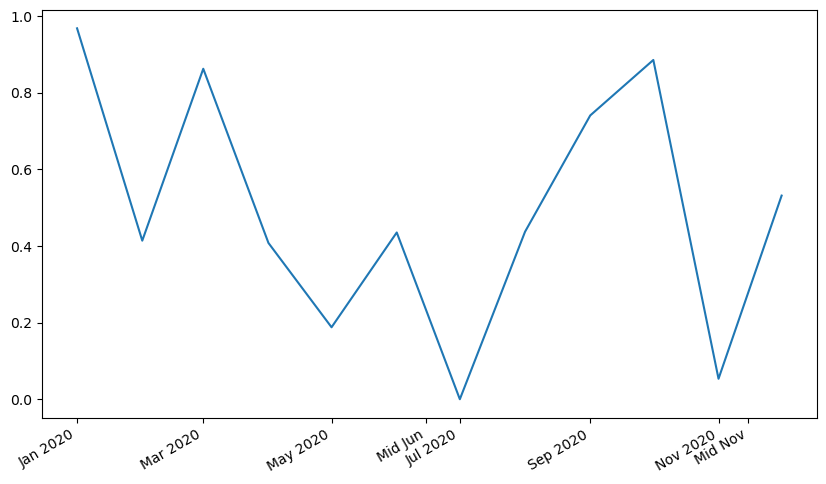

In [183]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime

# Sample data
dates = [datetime.datetime(2020, month, 1) for month in range(1, 13)]
values = np.random.rand(len(dates))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(dates, values)

# Usual date formatting for existing ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Get current ticks and labels
current_ticks = plt.gca().get_xticks()
current_labels = [mdates.num2date(tick).strftime('%b %Y') for tick in current_ticks]

# Define additional custom ticks and their labels
#additional_ticks = [mdates.date2num(datetime.datetime(2020, 6, 15)), mdates.date2num(datetime.datetime(2020, 11, 15))]
additional_labels = [mdates.num2date(ticks).strftime('%b %Y') for ticks in additional_ticks]

# Combine current and additional ticks and labels
all_ticks = np.concatenate((current_ticks, additional_ticks))
all_labels = current_labels + additional_labels

# Set the combined ticks and labels
plt.gca().set_xticks(all_ticks)
plt.gca().set_xticklabels(all_labels)

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

plt.show()
